In [0]:
#Сделано в google colab
#https://colab.research.google.com/drive/1C6LVw2XPtLSPLRe5wRDub3a22eDQ1OWZ#scrollTo=BYxGFPhWCl7p

# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [1]:
!pip3 install google.colab

      Successfully uninstalled google-auth-1.7.2
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1
  Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3
  Found existing installation: portpicker 1.3.1
    Uninstalling portpicker-1.3.1:
      Successfully uninstalled portpicker-1.3.1
  Found existing installation: idna 2.9
    Uninstalling idna-2.9:
      Successfully uninstalled idna-2.9
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [0]:
import os
import json
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

In [22]:
!pip3 install -q torch torchvision
!pip3 install -q Pillow

ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available

# Collab

In [6]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2020-05-14 00:42:25--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  35.7MB/s    in 15s     

2020-05-14 00:42:42 (34.9 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2020-05-14 00:42:51--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[========

# Home

In [0]:
import requests

In [8]:
f=open(r'test.zip',"wb")
ufr = requests.get("https://storage.googleapis.com/dlcourse_ai/test.zip")
f.write(ufr.content)
try: os.mkdir("test_kaggle")
except: pass
f.close()
!unzip -q "test.zip"

replace test_kaggle/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_kaggle/10001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_kaggle/10002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
f=open(r'train.zip',"wb")
ufr = requests.get("https://storage.googleapis.com/dlcourse_ai/train.zip")
f.write(ufr.content)
try: os.mkdir("train_kaggle")
except: pass
f.close()
!unzip -q "train.zip"

# Основная работа

In [9]:
train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))


test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

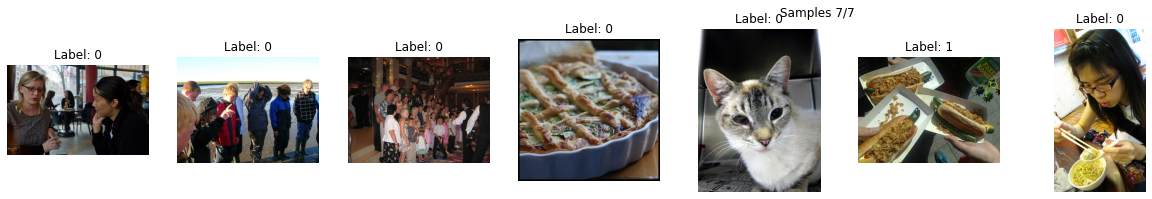

In [24]:
class HotdogOrNotDataset():
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):        
        img_name = os.listdir(self.folder)[index]
        img_path = os.path.join(self.folder, img_name)

        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        
        y = 1 if any(x in img_name for x in ['frankfurter', 'chili-dog', 'hotdog']) else 0
        
        img_id = img_name.split('_')[1].split('.')[0]

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=True)

visualize_samples(orig_dataset, indices, "Samples")

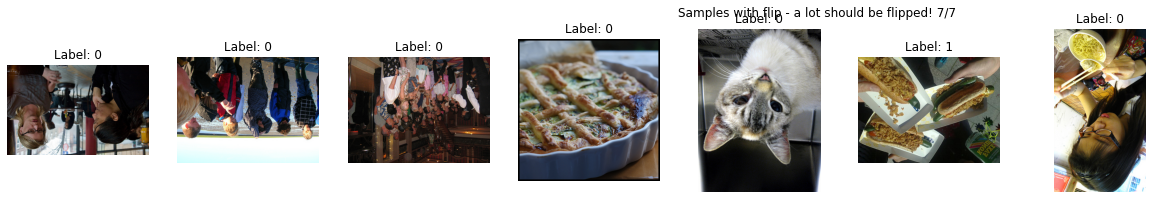

In [25]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))
visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [0]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    acc = [torch.mean((model(batch[0].to(device)).argmax(axis=1) == batch[1].to(device)).float()) 
           for batch in loader]
    acc = torch.mean(torch.Tensor(acc))
    return acc

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [29]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


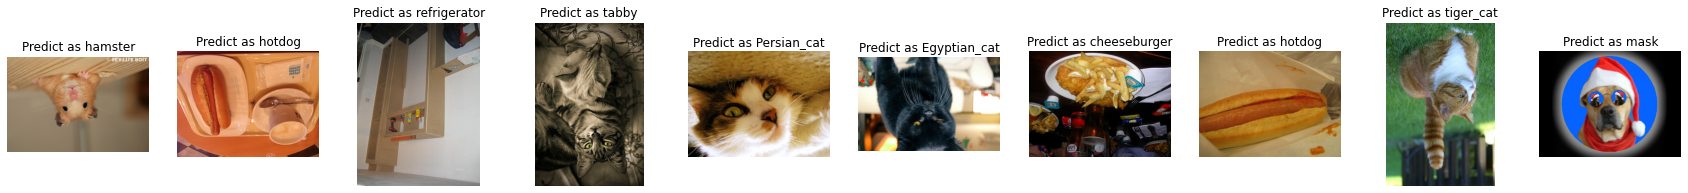

In [30]:
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
classes = load_imagenet_classes()

plt.figure(figsize=(10*3,3))
model.eval()
for ind, value in enumerate(indices):
    plt.subplot(1,10,ind+1)
    img, y, _ = train_dataset[value]
    img = img.unsqueeze(0)
    ans = model(img)
    _, ans = torch.max(ans, 1)
    plt.title(f"Predict as {classes[int(ans)]}")
    img, y, _ = dataset[value]
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [32]:
import torch.nn as nn
import torch.optim as optim


model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)

parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.386372, Train accuracy: 0.815096, Val accuracy: 0.927431
Average loss: 0.213310, Train accuracy: 0.916644, Val accuracy: 0.943403


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [33]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)

parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, 
                                                       val_loader, loss, 
                                                       optimizer, 2)



Average loss: 0.310391, Train accuracy: 0.861797, Val accuracy: 0.949306
Average loss: 0.135247, Train accuracy: 0.952484, Val accuracy: 0.952431


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [34]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
loss = nn.CrossEntropyLoss()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)

parameters = [{'params': list(model.parameters())[:-1], 'lr': 1e-2},
              {'params': list(model.parameters())[-1:], 'lr': 1e-3}]

optimizer = optim.SGD(parameters, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, 
                                                       val_loader, loss, 
                                                       optimizer, 2)

Average loss: 0.251416, Train accuracy: 0.897095, Val accuracy: 0.919792
Average loss: 0.077427, Train accuracy: 0.972305, Val accuracy: 0.942014


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    loader = torch.utils.data.DataLoader(dataset, 
                                         sampler=SubsetSampler(indices))
    predictions = []
    ground_truth = []
  
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred = model(x_gpu)
        _, indices = torch.max(pred, 1)
        predictions.append(int(indices))
        ground_truth.append(int(y_gpu))
    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

In [0]:
def get_fp_and_fn_samples(predictions, gt, val_indices):
    false_positive_indices = []
    false_negative_indices = []

    for ind, gts in enumerate(gt):
        if not gts and gts != predictions[ind]:
            false_positive_indices.append(val_indices[ind])
        if gts and gts != predictions[ind]:
            false_negative_indices.append(val_indices[ind])
    return false_positive_indices, false_negative_indices



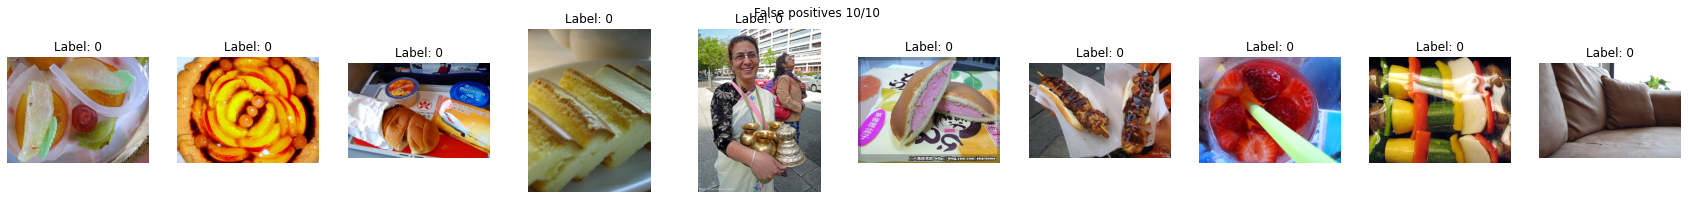

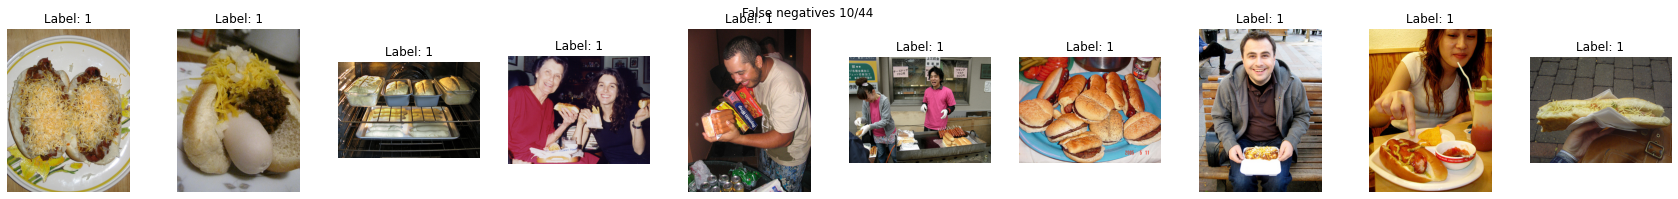

In [37]:
false_positive_indices, false_negative_indices = \
                       get_fp_and_fn_samples(predictions, gt, val_indices)

visualize_samples(orig_dataset, false_positive_indices, "False positives")

visualize_samples(orig_dataset, false_negative_indices, "False negatives")



In [38]:
import sklearn.metrics as metrics

def binary_classification_metrics(prediction, ground_truth):
    b = 1

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for i in range(len(ground_truth)):
        if prediction[i] == ground_truth[i] == 1:
            true_positive += 1
        if ground_truth[i] == 1 and prediction[i] != ground_truth[i]:
            false_positive += 1
        if prediction[i] == ground_truth[i] == 0:
            true_negative += 1
        if ground_truth[i] == 0 and prediction[i] != ground_truth[i]:
            false_negative += 1
    try:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        accuracy = (true_positive + true_negative) / \
                (true_positive + true_negative + false_positive + false_negative)

        f1 = (1+b) * (precision * recall) / ((b**2 * precision) + recall)
        return precision, recall, f1, accuracy    
    except:
        return 0, 0, 0, 0


precision, recall, f1, _ = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.898, P: 0.845, R: 0.960


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [0]:
from collections import namedtuple
Hyperparams = namedtuple("Hyperparams", 
                         ['learning_rate1', 'learning_rate2', 'anneal_epochs', 
                          'r1', 'r2', 'epochs'])

RunResult = namedtuple("RunResult", ['model', 'optimizer', 
                                     'train_history', 'val_history', 'f1_val'])
run_record = {}



In [40]:
import torch.nn as nn
import torch.optim as optim

epoch = 6
anneal_epochs = [1, 2]
reg = [1e-4, 1e-3, 1e-2]
lrs = [1e-2, 1e-3, 1e-4]

for ae in anneal_epochs:
    for r1 in reg:
        for r2 in reg:
            for lr1 in lrs:
                for lr2 in lrs:
                    hprparams = Hyperparams(lr1, lr2, ae, r1, r2, epoch)
                    print(hprparams)

                    model = models.resnet18(pretrained=True)

                    num_ftrs = model.fc.in_features
                    model.fc = nn.Linear(num_ftrs, 2)
                    model.type(torch.cuda.FloatTensor)
                    model.to(device)

                    parameters = [{'params': list(model.parameters())[:-1],
                                 'lr':lr1, 'reg': r1}, 
                                {'params': list(model.parameters())[-1], 
                                 'lr': lr2, 'reg': r2}]

                    optimizer = optim.Adam(parameters)
                    loss = nn.CrossEntropyLoss()
                    loss_history, train_history, val_history = \
                                                  train_model(model, train_loader, 
                                                              val_loader, loss, 
                                                              optimizer, epoch)

                    predictions, gt = evaluate_model(model, train_dataset, val_indices)
                    precision, recall, f1, _ = \
                                      binary_classification_metrics(predictions, gt)

                    score = RunResult(model, optimizer, train_history, val_history, f1)
                    run_record[hprparams] = score
                    print(f"f1: {score.f1_val}")

Hyperparams(learning_rate1=0.01, learning_rate2=0.01, anneal_epochs=1, r1=0.0001, r2=0.0001, epochs=6)
Average loss: 0.803152, Train accuracy: 0.654901, Val accuracy: 0.693750
Average loss: 0.598585, Train accuracy: 0.672550, Val accuracy: 0.693056
Average loss: 0.567915, Train accuracy: 0.697529, Val accuracy: 0.592361
Average loss: 0.559200, Train accuracy: 0.707304, Val accuracy: 0.693056
Average loss: 0.628228, Train accuracy: 0.732283, Val accuracy: 0.712500
Average loss: 0.504420, Train accuracy: 0.761607, Val accuracy: 0.713194
f1: 0.5931677018633542
Hyperparams(learning_rate1=0.01, learning_rate2=0.001, anneal_epochs=1, r1=0.0001, r2=0.0001, epochs=6)
Average loss: 1.065377, Train accuracy: 0.667662, Val accuracy: 0.683333
Average loss: 0.595695, Train accuracy: 0.690198, Val accuracy: 0.686111
Average loss: 0.560341, Train accuracy: 0.705132, Val accuracy: 0.734375
Average loss: 0.571237, Train accuracy: 0.699430, Val accuracy: 0.691319
Average loss: 0.539418, Train accuracy: 

RuntimeError: ignored

## Визуализируйте ошибки лучшей модели

In [42]:
best_model = None
best_val_f1 = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_f1 is None or best_val_f1 < run_result.f1_val:
        best_val_f1 = run_result.f1_val
        best_hyperparams = hyperparams
        best_run = run_result 
        best_model = run_result.model

print("Best validation f1: %4.2f, best hyperparams: %s" % (best_val_f1, best_hyperparams))

Best validation f1: 0.93, best hyperparams: Hyperparams(learning_rate1=0.0001, learning_rate2=0.01, anneal_epochs=1, r1=0.001, r2=0.001, epochs=6)
